# Interacting with CLIP

This is a self-contained notebook that shows how to download and run CLIP models, calculate the similarity between arbitrary image and text inputs, and perform zero-shot image classifications.

# Preparation for Colab

Make sure you're running a GPU runtime; if not, select "GPU" as the hardware accelerator in Runtime > Change Runtime Type in the menu. The next cells will install the `clip` package and its dependencies, and check if PyTorch 1.7.1 or later is installed.

In [1]:
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /private/var/folders/zx/46y7zv8x5gd6xfp0s16kr0w00000gp/T/pip-req-build-1jxuzsi7
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /private/var/folders/zx/46y7zv8x5gd6xfp0s16kr0w00000gp/T/pip-req-build-1jxuzsi7
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done


In [2]:
import numpy as np
import torch
from pkg_resources import packaging

print("Torch version:", torch.__version__)


Torch version: 2.2.2


# Loading the model

`clip.available_models()` will list the names of available CLIP models.

In [4]:
import clip

clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [116]:
model, preprocess = clip.load("ViT-B/32")
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


# Image Preprocessing

We resize the input images and center-crop them to conform with the image resolution that the model expects. Before doing so, we will normalize the pixel intensity using the dataset mean and standard deviation.

The second return value from `clip.load()` contains a torchvision `Transform` that performs this preprocessing.



In [7]:
preprocess

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x1611bde40>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

# Text Preprocessing

We use a case-insensitive tokenizer, which can be invoked using `clip.tokenize()`. By default, the outputs are padded to become 77 tokens long, which is what the CLIP models expects.

In [9]:
clip.tokenize("one two three")

tensor([[49406,   637,  1237,  2097, 49407,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]], dtype=torch.int32)

# Setting up input images and texts

We are going to feed 8 example images and their textual descriptions to the model, and compare the similarity between the corresponding features.

The tokenizer is case-insensitive, and we can freely give any suitable textual descriptions.

In [11]:
import os
import skimage
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import urllib.request
from collections import OrderedDict
import torch
import time

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Building features

We normalize the images, tokenize each text input, and run the forward pass of the model to get the image and text features.

In [13]:
def loadImage(url, rows=5, cols=5):
  original_images = []
  urllib.request.urlretrieve(
    url,
    "img.gif")
  im = Image.open("img.gif")
  try:
    while 1:
      im.seek(im.tell()+1)
      original_images.append(im.convert("RGB"))
  except EOFError:
    pass

  print(len(original_images))

  processed_images = []

  for image in original_images:
    processed_images.append(preprocess(image))

  plt.figure(figsize=(20, 10))
  start = 0
  for i in range(rows*cols):
    plt.subplot(rows, cols, i+1)
    plt.imshow(original_images[start+i])
    plt.axis('off')
    #plt.title(str(start+i))
  plt.tight_layout()
  plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)

  return original_images, processed_images



## Renaming Files (Data Collection)

In [163]:
import os

def rename_files_in_folder(folder_path, start_value, file_extension):
    files = sorted(os.listdir(folder_path))
    for i, filename in enumerate(files):
        if filename == ".DS_Store":
            continue
        new_name = f"{start_value + i}.{file_extension}"
        old_file = os.path.join(folder_path, filename)
        new_file = os.path.join(folder_path, new_name)
        os.rename(old_file, new_file)
        print(f"Renamed {filename} to {new_name}")

In [165]:
from PIL import Image
import matplotlib.pyplot as plt

cached_images = {}

def loadImageLocal(local_path, rows=5, cols=5):
    if local_path in cached_images: return cached_images[local_path]
    original_images = []

    im = Image.open(local_path)
    
    try:
        im.seek(im.tell())
        original_images.append(im.convert("RGB"))
        while 1:
            im.seek(im.tell()+1)
            original_images.append(im.convert("RGB"))
    except EOFError:
        pass

    processed_images = []

    for image in original_images:
        processed_images.append(preprocess(image))

    cached_images[local_path] = (original_images, processed_images)
    return original_images, processed_images


In [21]:
model

CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          

In [31]:
def findMatch(original_images, processed_images, texts, show_output=False):
    t1 = time.perf_counter()
    image_input = torch.tensor(np.stack(processed_images))
    text_tokens = clip.tokenize(["This is " + desc for desc in texts])

    with torch.no_grad():
        image_features = model.encode_image(image_input).float()
        text_features = model.encode_text(text_tokens).float()

    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T
    t2 = time.perf_counter()
    
    if show_output:
        plt.figure(figsize=(18, 6 * len(texts)))
    
    results = []
    for i, text in enumerate(texts):
        if show_output:
            plt.subplot(len(texts), 2, 1 + 2 * i)
            plt.plot(range(len(similarity[i])), similarity[i])
        results.append(np.argmax(similarity[i]))
        if show_output:
            plt.subplot(len(texts), 2, 2 + 2 * i)
            plt.imshow(original_images[np.argmax(similarity[i])])
            plt.title(text, fontdict={'fontsize': 40})
    if show_output:
        plt.tight_layout()
    return results

In [33]:
from PIL import Image, ImageTk
import tkinter as tk

def showFrames(path):
    gif_path = path
    gif = Image.open(gif_path)
    
    root = tk.Tk()
    root.title("Picking Best Frame")
    
    frame_number = 0
    frames = []
    while True:
        try:
            gif.seek(frame_number)
            frame = gif.copy()
            frames.append(frame)
            frame_number += 1
        except EOFError:
            break
    
    def display_frame(index):
        frame_label.config(text=f"Frame {index}")
        img = ImageTk.PhotoImage(frames[index])
        frame_canvas.create_image(0, 0, anchor=tk.NW, image=img)
        frame_canvas.image = img
    
    frame_label = tk.Label(root, text="Frame 0", font=('Typo Round', 14))
    frame_label.pack()
    
    frame_canvas = tk.Canvas(root, width=frames[0].width, height=frames[0].height)
    frame_canvas.pack()
    
    display_frame(0)
    
    def next_frame(event):
        current_frame = int(frame_label.cget("text").split()[1])
        next_index = (current_frame + 1) % len(frames)
        display_frame(next_index)
    def prev_frame(event):
        current_frame = int(frame_label.cget("text").split()[1])
        next_index = (current_frame - 1) % len(frames)
        display_frame(next_index)
    
    root.bind('<Right>', next_frame)
    root.bind('<Left>', prev_frame)
    
    root.mainloop()


# Loading Data from `photo_data.csv`

In [40]:
import pandas as pd
import math
photo_data_csv = pd.read_csv("photo_data.csv")
photo_data_csv.head()

,Id,Description,Correct Frame,Unnamed: 3,Unnamed: 4,Gifs Completed,Unnamed: 6,Unnamed: 7,Frequency
0,1.0,woman falls down,19.0,NaN,NaN,1,1.0,True,2
1,2.0,woman falls down,9.0,NaN,NaN,2,2.0,True,1
2,3.0,guy falls down onto couch,28.0,NaN,NaN,3,3.0,True,2
3,4.0,person falls down,14.0,NaN,NaN,4,4.0,True,1
4,5.0,guy falls down,10.0,NaN,NaN,5,5.0,True,1


In [42]:
all_labeled_data = photo_data_csv.iloc[:, :3]

unfiltered_data_triples = list(all_labeled_data.itertuples(index=False, name=None))

labeled_data_float = list(filter(lambda x: not math.isnan(x[0]), unfiltered_data_triples))

labeled_data = list(map(lambda x: (f'gifs/{int(x[0])}.gif', x[1], int(x[2])), labeled_data_float))

X = labeled_data

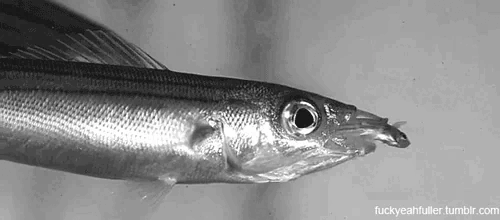

In [171]:
X_train[8][0]

In [189]:
from IPython.display import clear_output
from tqdm import tqdm

y_pred = []
X_lengths = []

X_frames = []
 
for gif_path, phrase, frame in tqdm(labeled_data):
    orig_imgs, proc_imgs = loadImageLocal(gif_path)
    X_lengths.append(len(orig_imgs))
    curr_frames = []
    for f_index, frame_pic in enumerate(orig_imgs):
        append = ""
        if f_index < frame:
            append = "before " * min(55, frame - f_index)
        elif f_index > frame:
            append = "after " * min(55, f_index - frame)
        else:
            append = ""
        after = ""
        if f_index == frame:
            after = ' now'
        curr_frames.append((frame_pic, append + phrase + after))
    X_frames.append(curr_frames)
    
    prediction = findMatch(orig_imgs, proc_imgs, [phrase])[0]
    print(f"Prediction for {gif_path}: Frame {prediction} vs. Actual: {frame}")
    print("For the phrase '" + phrase + "'")
    clear_output(wait=True)
    y_pred.append(prediction)

y_pred = np.array(y_pred)
X_lengths = np.array(X_lengths)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 272/272 [04:55<00:00,  1.09s/it]


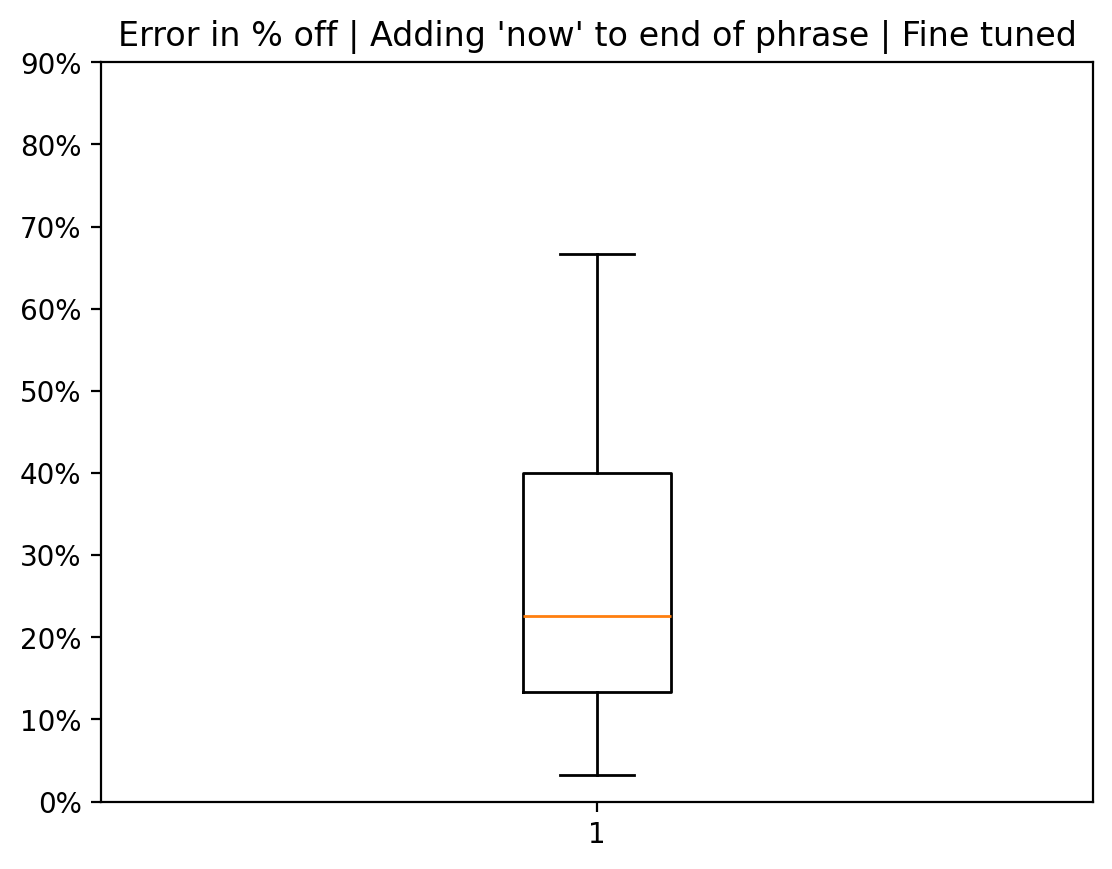

In [149]:
y_error = np.divide(np.abs(y_pred - photo_data_csv['Correct Frame'][0:25]), X_lengths) * 100
plt.boxplot(y_error)
plt.yticks(np.arange(0, 100, 10), np.char.add(np.arange(0, 100, 10).astype("str"), '%'))
plt.title("Error in % off | Adding 'now' to end of phrase | Fine tuned")
plt.show()

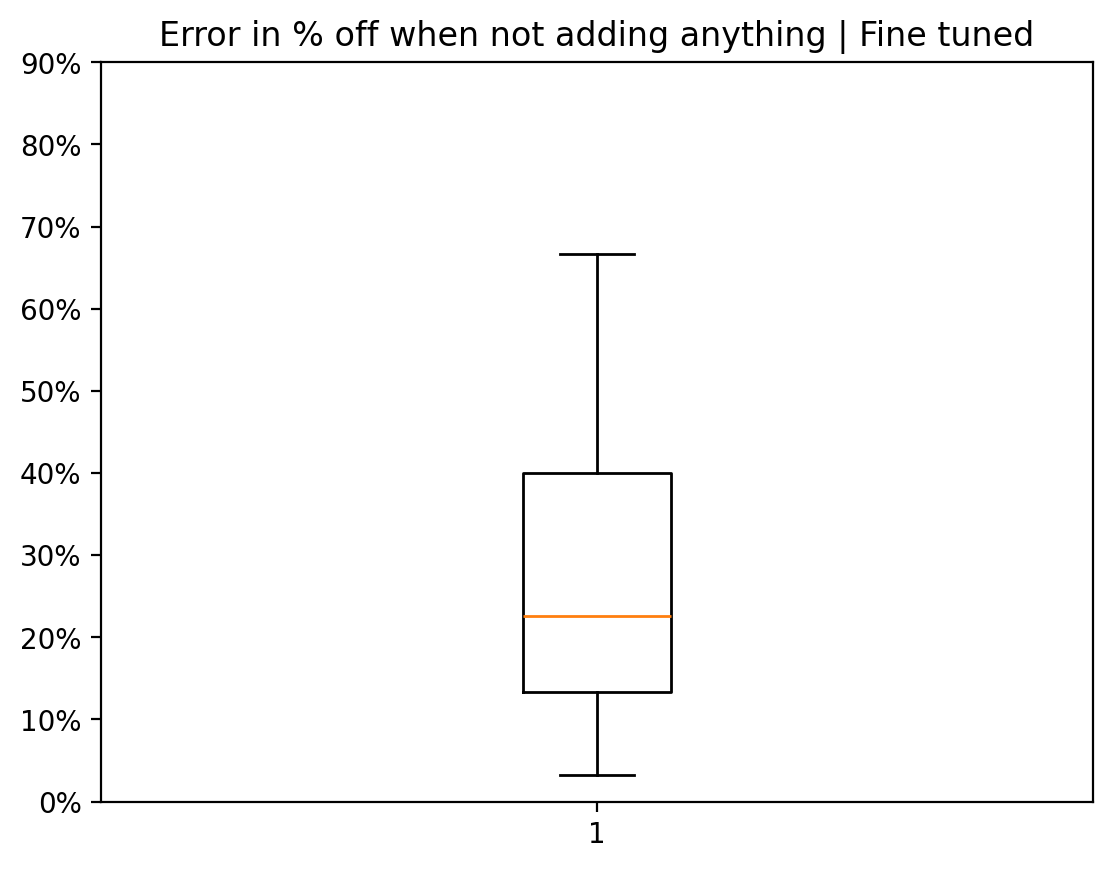

In [152]:
y_error = np.divide(np.abs(y_pred - photo_data_csv['Correct Frame'][0:25]), X_lengths) * 100
plt.boxplot(y_error)
plt.yticks(np.arange(0, 100, 10), np.char.add(np.arange(0, 100, 10).astype("str"), '%'))
plt.title("Error in % off when not adding anything | Fine tuned")
plt.show()

In [411]:
len(X_frames)

272

# Actual Training

In [282]:
pip install transformers

Note: you may need to restart the kernel to use updated packages.


In [173]:
model.load_state_dict(torch.load('saved_model.pth', weights_only=True, map_location=torch.device('cpu')))

FileNotFoundError: [Errno 2] No such file or directory: 'saved_model.pth'

In [175]:
model.eval()

correct_predictions = 0
total_samples = 0

with torch.no_grad():
    for batch in tqdm(test_dataloader, total=len(test_dataloader)):
        images, texts = batch
        images = images.to(device)
        texts = texts.to(device)

        logits_per_image, logits_per_text = model(images, texts)

        ground_truth = torch.arange(len(images), dtype=torch.long, device=device)
        image_predictions = logits_per_image.argmax(dim=1)
        text_predictions = logits_per_text.argmax(dim=1)

        correct_predictions += (image_predictions == ground_truth).sum().item()
        total_samples += len(images)

# Calculate final accuracy
accuracy = correct_predictions / total_samples
print(f"Test Accuracy: {accuracy:.4f}")


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [01:20<00:00,  3.37s/it]

Test Accuracy: 0.0134


# Start

In [191]:
import json
from PIL import Image

from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import clip
from transformers import CLIPProcessor, CLIPModel

In [193]:
# Load the CLIP model and processor
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

/opt/anaconda3/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [195]:
# Choose computation device
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [183]:
# Load pre-trained CLIP model
model, preprocess = clip.load("ViT-B/32", device=device, jit=False)

In [197]:
class image_title_dataset():
    def __init__(self, list_image,list_txt):
        self.image = list_image
        self.title  = clip.tokenize(list_txt)

    def __len__(self):
        return len(self.title)

    def __getitem__(self, idx):
        image = preprocess(self.image[idx])
        title = self.title[idx]
        return image, title

In [199]:
train_cycle = 1  # Adjust this between 1 and 5

slice_length = len(X_frames) // 5

start_index = (train_cycle - 1) * slice_length
end_index = start_index + slice_length

X_test = X_frames[start_index:end_index]

X_train = X_frames[:start_index] + X_frames[end_index:]

print(f"Training data for train_cycle {train_cycle}: {len(X_train)} elements")
print(f"Testing data for train_cycle {train_cycle}: {len(X_test)} elements")


Training data for train_cycle 1: 218 elements
Testing data for train_cycle 1: 54 elements


In [201]:
X_train_flatten = []
X_test_flatten = []
for GIF in X_train:
    for frame in GIF:
        X_train_flatten.append(frame)
for GIF in X_test:
    for frame in GIF:
        X_test_flatten.append(frame)

X_train = X_train_flatten
X_test = X_test_flatten

In [203]:
X_test[5]

(<PIL.Image.Image image mode=RGB size=220x220>,
 'before before before before before before before before before before before before before before woman falls down')

In [205]:
def loadFromX(X):
    list_image = []
    list_txt = []
    for image, desc in X:
        img_path = image
        caption = desc
        list_image.append(img_path)
        list_txt.append(caption)
    return list_image, list_txt

In [207]:
list_image_train, list_txt_train = loadFromX(X_train)
dataset_train = image_title_dataset(list_image_train, list_txt_train)
train_dataloader = DataLoader(dataset_train, batch_size=100, shuffle=True) #Define your own dataloader

In [209]:
list_image_test, list_txt_test = loadFromX(X_test)
dataset_test = image_title_dataset(list_image_test, list_txt_test)
test_dataloader = DataLoader(dataset_test, batch_size=100, shuffle=True) #Define your own dataloader

In [211]:
# Function to convert model's parameters to FP32 format
def convert_models_to_fp32(model):
    for p in model.parameters():
        p.data = p.data.float()
        p.grad.data = p.grad.data.float()
if device == "cpu":
  model.float()

In [213]:
# Prepare the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5,betas=(0.9,0.98),eps=1e-6,weight_decay=0.2) # the lr is smaller, more safe for fine tuning to new dataset


# Specify the loss function
loss_img = nn.CrossEntropyLoss()
loss_txt = nn.CrossEntropyLoss()

In [215]:
num_epochs = 20
for epoch in range(num_epochs):
    pbar = tqdm(train_dataloader, total=len(train_dataloader))
    for batch in pbar:
        optimizer.zero_grad()

        images,texts = batch

        images= images.to(device)
        texts = texts.to(device)

        # Forward pass
        logits_per_image, logits_per_text = model(images, texts)

        # Compute loss
        ground_truth = torch.arange(len(images),dtype=torch.long,device=device)
        total_loss = (loss_img(logits_per_image,ground_truth) + loss_txt(logits_per_text,ground_truth))/2

        # Backward pass
        total_loss.backward()
        if device == "cpu":
            optimizer.step()
        else :
            convert_models_to_fp32(model)
            optimizer.step()
            clip.model.convert_weights(model)

        pbar.set_description(f"Epoch {epoch}/{num_epochs}, Loss: {total_loss.item():.4f}")

  0%|                                                                                                                                             | 0/99 [00:00<?, ?it/s]


RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [100, 77]

In [92]:
torch.save(model.state_dict(), 'before_model_after.pth')